#### Analyzing Neural Time Series Data
Python code for Chapter 20 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fft import fft, ifft
from scipy.signal import find_peaks

In [57]:
# Load sample EEG data
eeg_data = loadmat('../data/sampleEEGdata.mat')
EEG = eeg_data['EEG'][0, 0]

# Define channel to plot
chan2plot = 'O1'

# Wavelet parameters
min_freq = 2
max_freq = 30
num_frex = 20

# Baseline time window
baseline_time = [-400, -100]

# Other wavelet parameters
frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)
time = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
half_of_wavelet_size = (len(time) - 1) // 2

# FFT parameters
n_wavelet = len(time)
n_data = EEG['pnts'][0][0] * EEG['trials'][0][0]
n_convolution = [n_wavelet + n_data - 1, n_wavelet + n_data - 1, n_wavelet + EEG['pnts'][0][0] - 1]

# Find sensor index
sensoridx = EEG['chanlocs'][0]['labels']==chan2plot

# Compute ERP
erp = np.mean(EEG['data'][sensoridx, :, :], axis=2)

# Compute induced power by subtracting ERP from each trial
induced_EEG = EEG['data'][sensoridx, :, :] - np.tile(erp[..., np.newaxis], (EEG['trials'][0][0]))

# FFT of data
fft_EEG = [
    fft(np.reshape(EEG['data'][sensoridx, :, :], -1, 'F'), n_convolution[0]),  # total
    fft(np.reshape(induced_EEG, -1, 'F'), n_convolution[1]),  # induced
    fft(erp, n_convolution[2])[0]  # evoked
]

# Convert baseline from ms to indices
baseline_idx = [np.argmin(np.abs(EEG['times'][0] - bt)) for bt in baseline_time]

# Initialize output time-frequency data
tf = np.zeros((4, len(frequencies), EEG['pnts'][0][0]))

for fi in range(len(frequencies)):
    
    # Create wavelet
    wavelet = np.exp(2 * 1j * np.pi * frequencies[fi] * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * frequencies[fi]))**2)) / frequencies[fi]
    
    # Run convolution for each of total, induced, and evoked
    for i in range(3):
        
        # Take FFT of wavelet
        fft_wavelet = fft(wavelet, n_convolution[i])
        
        # Convolution
        convolution_result_fft = ifft(fft_wavelet * fft_EEG[i], n_convolution[i])
        convolution_result_fft = convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size]
        
        # Reshaping and trial averaging is done only on all trials
        if i < 2:
            convolution_result_fft = np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
            
            # Compute power
            tf[i, fi, :] = np.mean(np.abs(convolution_result_fft)**2, axis=1)
        else:
            # With only one trial-length, just compute power with no averaging
            tf[i, fi, :] = np.abs(convolution_result_fft)**2
        
        # dB correct power
        tf[i, fi, :] = 10 * np.log10(tf[i, fi, :] / np.mean(tf[i, fi, baseline_idx[0]:baseline_idx[1]]))
        
        # Inter-trial phase consistency on total EEG
        if i == 0:
            tf[3, fi, :] = np.abs(np.mean(np.exp(1j * np.angle(convolution_result_fft)), axis=1))

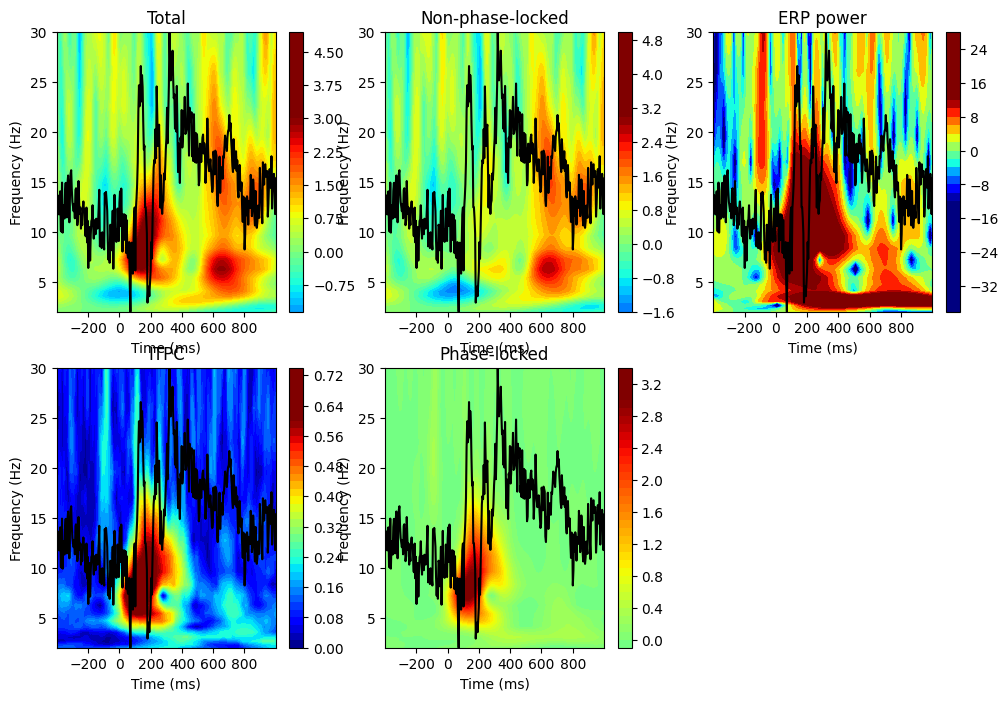

In [60]:
# Analysis labels
analysis_labels = ['Total', 'Non-phase-locked', 'ERP power', 'ITPC']

# Color limits
clims = [[-3, 3], [-3, 3], [-12, 12], [0, 0.6]]

# Scale ERP for plotting
erpt = (erp - np.min(erp)) / np.max(erp - np.min(erp))
erpt = erpt[0] * (frequencies[-1] - frequencies[0]) + frequencies[0]

# Plotting
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 3, i+1)
    plt.contourf(EEG['times'][0], frequencies, tf[i, :, :], 40, cmap='jet')
    plt.clim(clims[i])
    plt.xlim([-400, 1000])
    plt.xticks(np.arange(-200, 801, 200))
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title(analysis_labels[i])
    plt.colorbar()
    plt.plot(EEG['times'][0], erpt, 'k')

plt.subplot(2, 3, 5)
plt.contourf(EEG['times'][0], frequencies, tf[0, :, :] - tf[1, :, :], 40, cmap='jet')
plt.clim(clims[0])
plt.xlim([-400, 1000])
plt.xticks(np.arange(-200, 801, 200))
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('Phase-locked')
plt.colorbar()
plt.plot(EEG['times'][0], erpt, 'k')
plt.show()

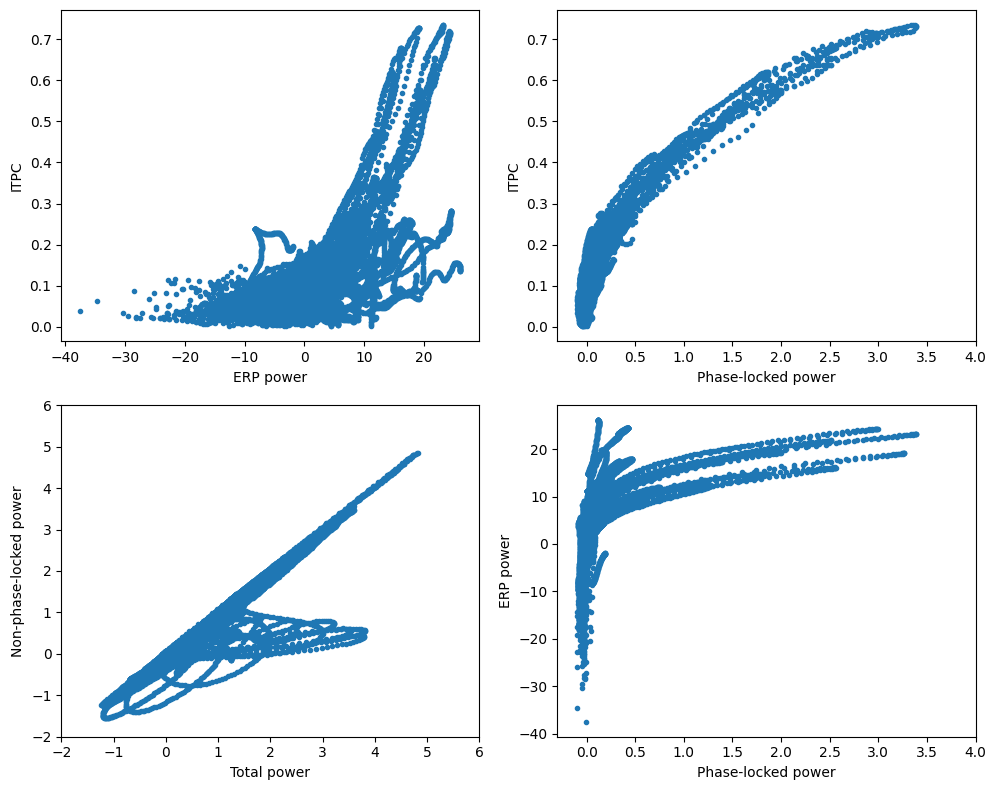

In [61]:
# Second figure plotting
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.plot(tf[2, :, :].flatten(), tf[3, :, :].flatten(), '.')
plt.xlabel('ERP power')
plt.ylabel('ITPC')

plt.subplot(222)
plt.plot((tf[0, :, :] - tf[1, :, :]).flatten(), tf[3, :, :].flatten(), '.')
plt.xlabel('Phase-locked power')
plt.ylabel('ITPC')
plt.xlim([-.3, 4])

plt.subplot(223)
plt.plot(tf[0, :, :].flatten(), tf[1, :, :].flatten(), '.')
plt.xlabel('Total power')
plt.ylabel('Non-phase-locked power')
plt.xlim([-2, 6])
plt.ylim([-2, 6])

plt.subplot(224)
plt.plot((tf[0, :, :] - tf[1, :, :]).flatten(), tf[2, :, :].flatten(), '.')
plt.xlabel('Phase-locked power')
plt.ylabel('ERP power')
plt.xlim([-.3, 4])

plt.tight_layout()
plt.show()